# Pregunta 2

# Generación y descripción del dataset

In [1]:
import pandas as pd
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df_csv = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])


In [2]:
df = df_csv.copy()
df = pd.get_dummies(df,columns=["CHAS"]) #to categorical
from sklearn.cross_validation import train_test_split
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)

from sklearn.preprocessing import StandardScaler
y_train = df_train.pop('MEDV').reshape(-1,1)
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)

y_test = df_test.pop('MEDV').reshape(-1,1)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD


def compile_network(lr=0.01, hidden_units=200, hidden_activation="sigmoid"):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform'))
    model.add(Activation(hidden_activation))
    model.add(Dense(1, kernel_initializer='uniform'))
    model.add(Activation('linear'))
    sgd = SGD(lr=lr)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model
    
def fit_network(model, epochs=300):
    hist = model.fit(X_train_scaled, y_train, epochs=epochs,
        verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))
    return hist

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Gradientes de red shallow

El desvanecimiento de los gradientes es un problema que ocurre en redes de mayor profundidad. A medida que se transmite la información en el back propagation, el dominio de los pesos disminuye progresivamente, hasta ser de ordenes de magnitud diferente que las primeras capas. Este efecto es negativo ya que no permite que fluya de manera correcta la información por la red, haciendo que esta tenga un sesgo no deseado.

A continuación, se estudiará que sucede con los gradientes en una red shallow.

In [4]:
import seaborn
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras
from keras import backend as K
import tensorflow as tf


# Definición del modelo
model = compile_network()

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

layers_before = [
    {
        "weights": [item for sublist in evaluated_gradients[0] for item in sublist],
        "bias": evaluated_gradients[1]
    }, {
        "weights": [item for sublist in evaluated_gradients[2] for item in sublist],
        "bias": evaluated_gradients[3]
    }
]


fit_network(model)

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

layers_after = [
    {
        "weights": [item for sublist in evaluated_gradients[0] for item in sublist],
        "bias": evaluated_gradients[1]
    }, {
        "weights": [item for sublist in evaluated_gradients[2] for item in sublist],
        "bias": evaluated_gradients[3]
    }
]



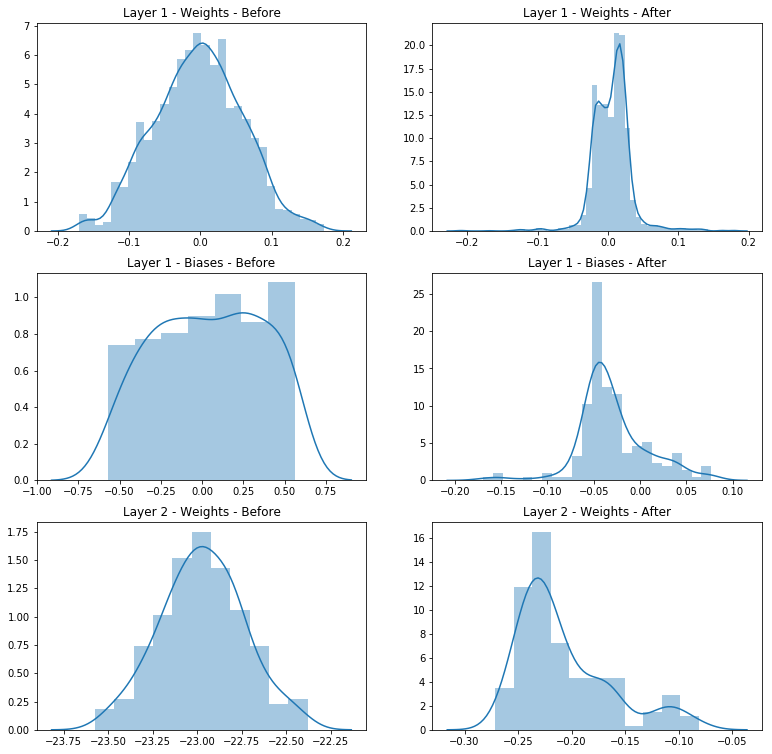

In [5]:
import seaborn
import matplotlib.pyplot as plt

# Flatten the list
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 13))

axes[0, 0].set_title("Layer 1 - Weights - Before")
seaborn.distplot(layers_before[0]["weights"], label="0", ax=axes[0, 0])
axes[0, 1].set_title("Layer 1 - Weights - After")
seaborn.distplot(layers_after[0]["weights"], label="0", ax=axes[0, 1])

axes[1, 0].set_title("Layer 1 - Biases - Before")
seaborn.distplot(layers_before[0]["bias"], label="0", ax=axes[1, 0])
axes[1, 1].set_title("Layer 1 - Biases - After")
seaborn.distplot(layers_after[0]["bias"], label="0", ax=axes[1, 1])

axes[2, 0].set_title("Layer 2 - Weights - Before")
seaborn.distplot(layers_before[1]["weights"], label="0", ax=axes[2, 0])
axes[2, 1].set_title("Layer 2 - Weights - After")
seaborn.distplot(layers_after[1]["weights"], label="0", ax=axes[2, 1])

plt.show()

Se puede observar que inicialmente los pesos están distribuidos de formal normal y uniforme dependiendo de la capa. Una vez que se realiza el entrenamiento, los pesos son modificados para poder representar correctamente el modelo que se quiere predecir.

Se puede notar que la magnitud de los pesos entre la segunda y primera capa difieren levemente tal y como es esperado, ya que el efecto del desvanecimiento de las gradientes afecta de menor manera a redes shallow.

# Gradientes de red deep

Para contrastar los resultados obtenidos anteriormente, se realiza el mismo estudio en una red profunda.

In [6]:
def compile_network_for_c(lr=0.01, hidden_units=200, hidden_activation="sigmoid"):
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(200,  kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model

In [7]:
import seaborn
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras
from keras import backend as K
import tensorflow as tf


# Definición del modelo
model = compile_network_for_c()

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

layers_before = []

for i in range(1, 13, 2):
    layers_before.append({
        "weights": [item for sublist in evaluated_gradients[i - 1] for item in sublist],
        "bias": evaluated_gradients[i]
    })


fit_network(model)

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

layers_after = []

for i in range(1, 13, 2):
    layers_after.append({
        "weights": [item for sublist in evaluated_gradients[i - 1] for item in sublist],
        "bias": evaluated_gradients[i]
    })



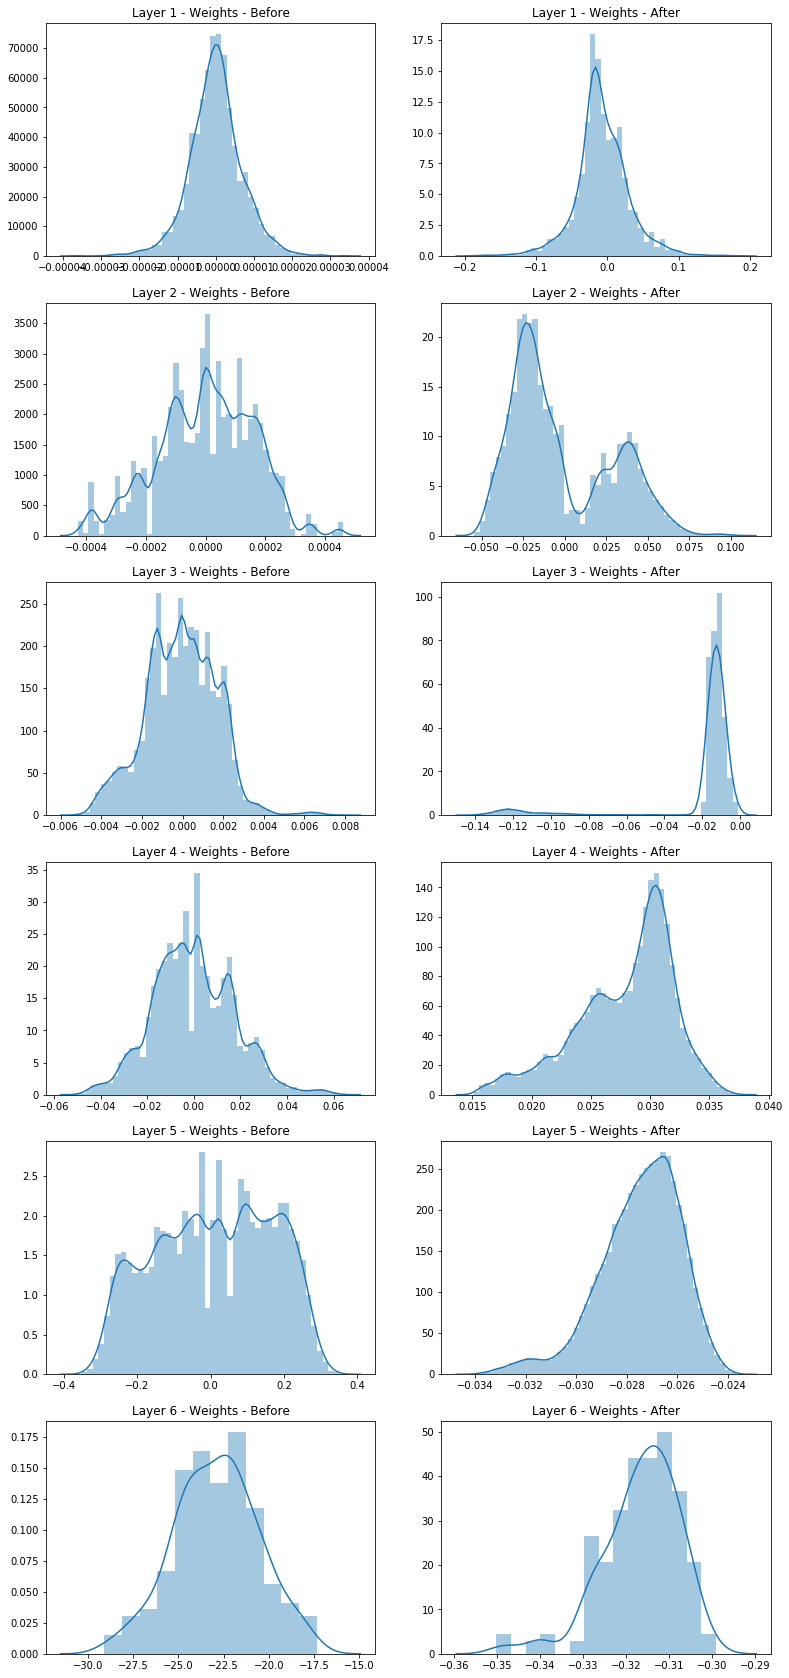

In [8]:
import seaborn
import matplotlib.pyplot as plt

# Flatten the list
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13, 30))

axes[0, 0].set_title("Layer 1 - Weights - Before")
seaborn.distplot(layers_before[0]["weights"], label="0", ax=axes[0, 0])
axes[0, 1].set_title("Layer 1 - Weights - After")
seaborn.distplot(layers_after[0]["weights"], label="0", ax=axes[0, 1])

axes[1, 0].set_title("Layer 2 - Weights - Before")
seaborn.distplot(layers_before[1]["weights"], label="0", ax=axes[1, 0])
axes[1, 1].set_title("Layer 2 - Weights - After")
seaborn.distplot(layers_after[1]["weights"], label="0", ax=axes[1, 1])

axes[2, 0].set_title("Layer 3 - Weights - Before")
seaborn.distplot(layers_before[2]["weights"], label="0", ax=axes[2, 0])
axes[2, 1].set_title("Layer 3 - Weights - After")
seaborn.distplot(layers_after[2]["weights"], label="0", ax=axes[2, 1])

axes[3, 0].set_title("Layer 4 - Weights - Before")
seaborn.distplot(layers_before[3]["weights"], label="0", ax=axes[3, 0])
axes[3, 1].set_title("Layer 4 - Weights - After")
seaborn.distplot(layers_after[3]["weights"], label="0", ax=axes[3, 1])

axes[4, 0].set_title("Layer 5 - Weights - Before")
seaborn.distplot(layers_before[4]["weights"], label="0", ax=axes[4, 0])
axes[4, 1].set_title("Layer 5 - Weights - After")
seaborn.distplot(layers_after[4]["weights"], label="0", ax=axes[4, 1])

axes[5, 0].set_title("Layer 6 - Weights - Before")
seaborn.distplot(layers_before[5]["weights"], label="0", ax=axes[5, 0])
axes[5, 1].set_title("Layer 6 - Weights - After")
seaborn.distplot(layers_after[5]["weights"], label="0", ax=axes[5, 1])

plt.show()

Es fácil notar que las magnitudes de los pesos se hace más pequeña a medida que

# Gradientes de red deep con Glorot

In [9]:
def compile_network_for_d(lr=0.01, hidden_units=200, hidden_activation="sigmoid"):
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
    model.add(Dense(200,  kernel_initializer='glorot_uniform',activation='sigmoid'))
    model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
    model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model

In [10]:
import seaborn
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras
from keras import backend as K
import tensorflow as tf


# Definición del modelo
model = compile_network_for_d()

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

layers_before = []

for i in range(1, 13, 2):
    layers_before.append({
        "weights": [item for sublist in evaluated_gradients[i - 1] for item in sublist],
        "bias": evaluated_gradients[i]
    })


fit_network(model)

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

layers_after = []

for i in range(1, 13, 2):
    layers_after.append({
        "weights": [item for sublist in evaluated_gradients[i - 1] for item in sublist],
        "bias": evaluated_gradients[i]
    })



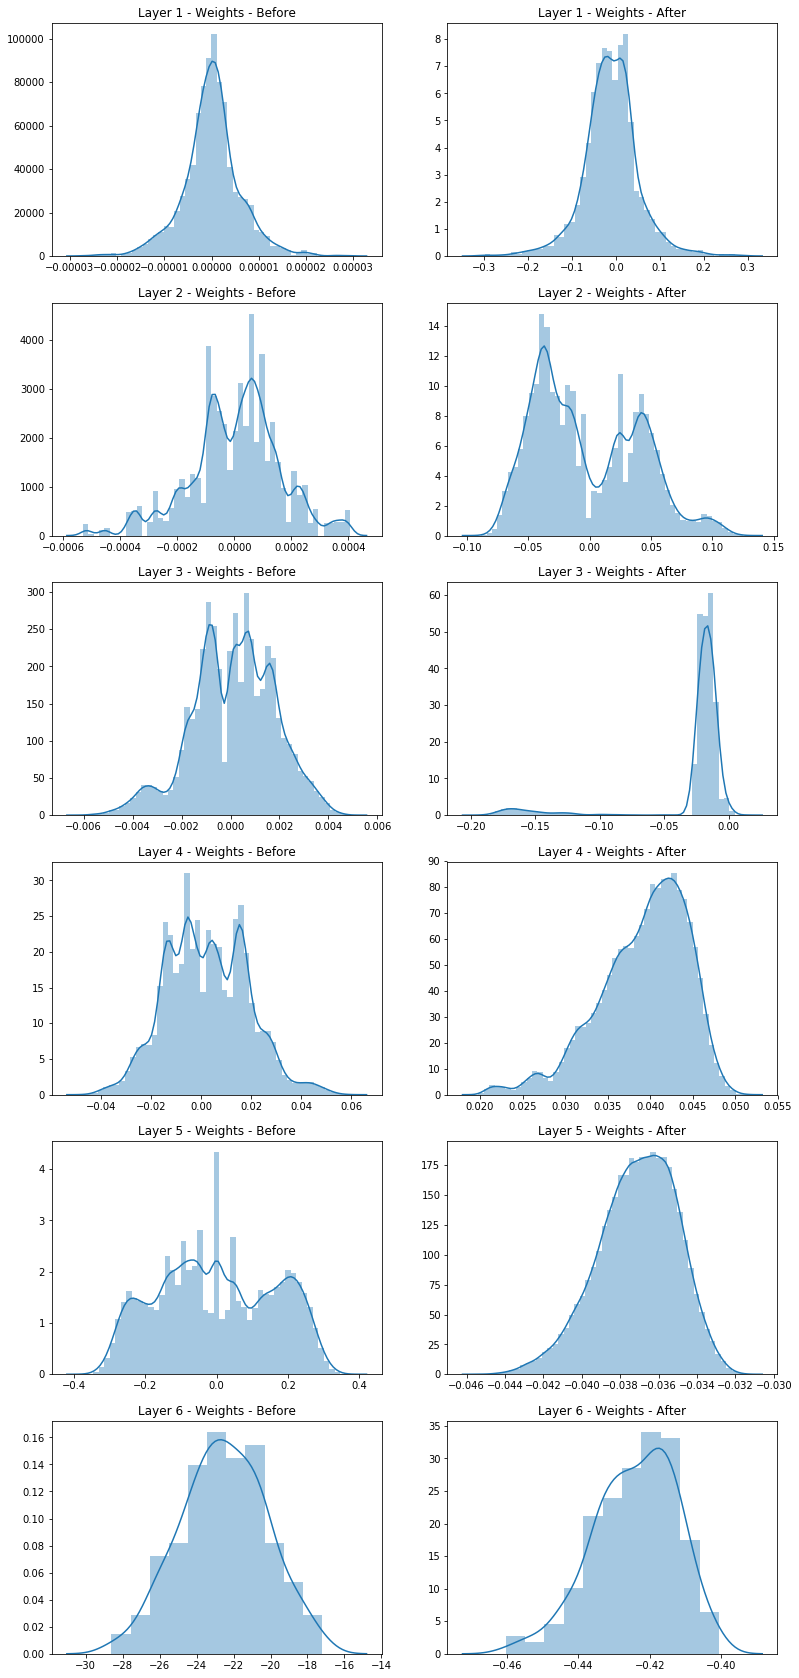

In [11]:
import seaborn
import matplotlib.pyplot as plt

print

# Flatten the list
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13, 30))

axes[0, 0].set_title("Layer 1 - Weights - Before")
seaborn.distplot(layers_before[0]["weights"], label="0", ax=axes[0, 0])
axes[0, 1].set_title("Layer 1 - Weights - After")
seaborn.distplot(layers_after[0]["weights"], label="0", ax=axes[0, 1])

axes[1, 0].set_title("Layer 2 - Weights - Before")
seaborn.distplot(layers_before[1]["weights"], label="0", ax=axes[1, 0])
axes[1, 1].set_title("Layer 2 - Weights - After")
seaborn.distplot(layers_after[1]["weights"], label="0", ax=axes[1, 1])

axes[2, 0].set_title("Layer 3 - Weights - Before")
seaborn.distplot(layers_before[2]["weights"], label="0", ax=axes[2, 0])
axes[2, 1].set_title("Layer 3 - Weights - After")
seaborn.distplot(layers_after[2]["weights"], label="0", ax=axes[2, 1])

axes[3, 0].set_title("Layer 4 - Weights - Before")
seaborn.distplot(layers_before[3]["weights"], label="0", ax=axes[3, 0])
axes[3, 1].set_title("Layer 4 - Weights - After")
seaborn.distplot(layers_after[3]["weights"], label="0", ax=axes[3, 1])

axes[4, 0].set_title("Layer 5 - Weights - Before")
seaborn.distplot(layers_before[4]["weights"], label="0", ax=axes[4, 0])
axes[4, 1].set_title("Layer 5 - Weights - After")
seaborn.distplot(layers_after[4]["weights"], label="0", ax=axes[4, 1])

axes[5, 0].set_title("Layer 6 - Weights - Before")
seaborn.distplot(layers_before[5]["weights"], label="0", ax=axes[5, 0])
axes[5, 1].set_title("Layer 6 - Weights - After")
seaborn.distplot(layers_after[5]["weights"], label="0", ax=axes[5, 1])

plt.show()

# Gradiente deep con ReLU

In [17]:
def compile_network_relu():
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
    model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
    model.add(Dense(200,  kernel_initializer='uniform',activation='relu'))
    model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
    model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
    sgd = SGD(lr=0.005)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model

def compile_network_relu_h():
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
    model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
    model.add(Dense(200,  kernel_initializer='he_uniform',activation='relu'))
    model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
    model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
    model.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))
    sgd = SGD(lr=0.001)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model

In [19]:
import seaborn
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras
from keras import backend as K
import tensorflow as tf


# Definición del modelo
model = compile_network_relu()

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

layers_before = []

for i in range(1, 13, 2):
    layers_before.append({
        "weights": [item for sublist in evaluated_gradients[i - 1] for item in sublist],
        "bias": evaluated_gradients[i]
    })


fit_network(model)

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

layers_after = []

for i in range(1, 13, 2):
    layers_after.append({
        "weights": [item for sublist in evaluated_gradients[i - 1] for item in sublist],
        "bias": evaluated_gradients[i]
    })



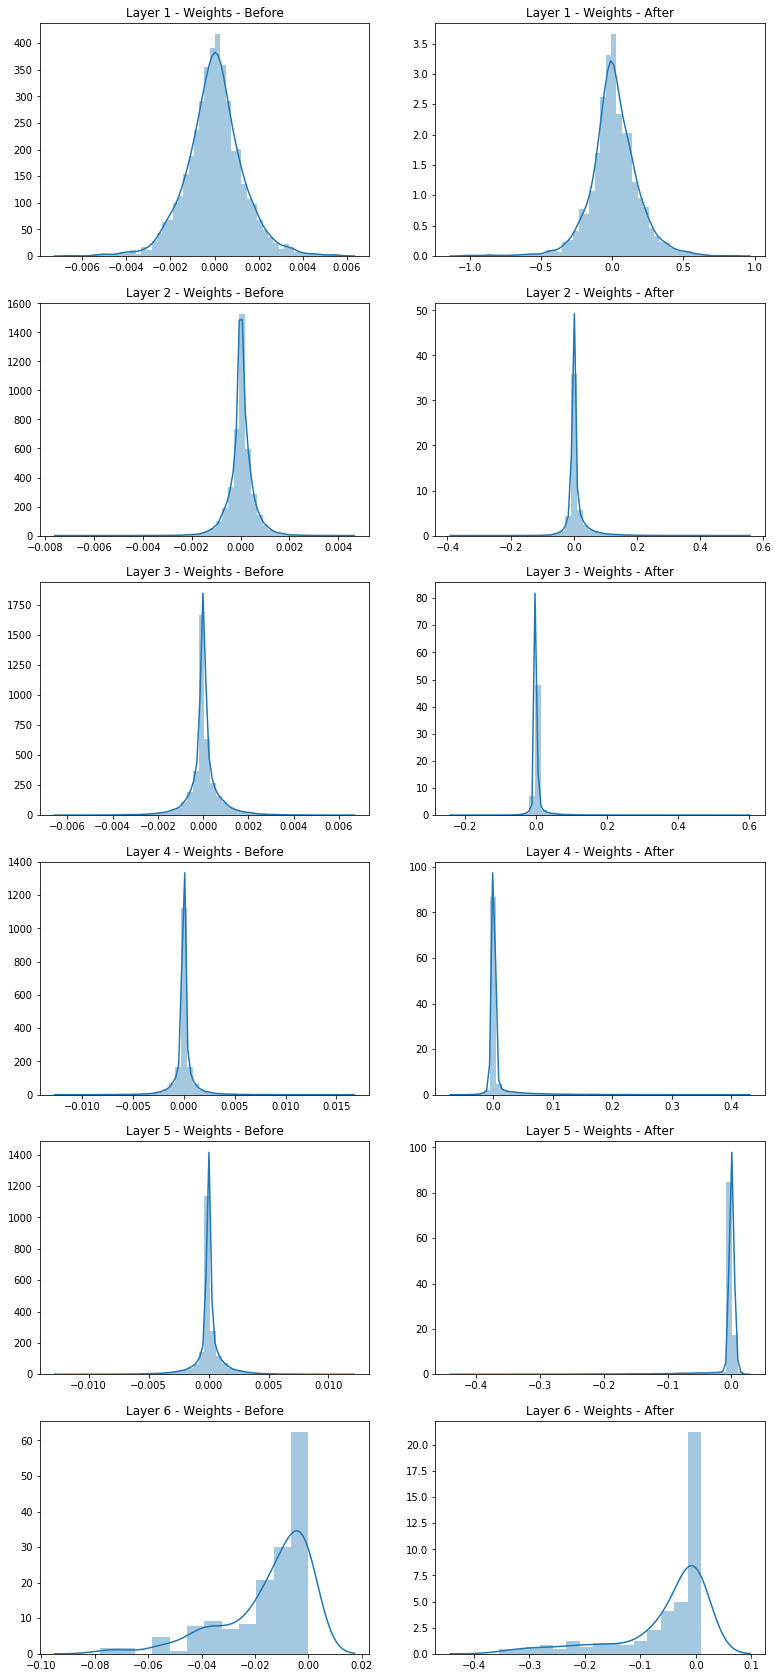

In [21]:
import seaborn
import matplotlib.pyplot as plt

print

# Flatten the list
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13, 30))

axes[0, 0].set_title("Layer 1 - Weights - Before")
seaborn.distplot(layers_before[0]["weights"], label="0", ax=axes[0, 0])
axes[0, 1].set_title("Layer 1 - Weights - After")
seaborn.distplot(layers_after[0]["weights"], label="0", ax=axes[0, 1])

axes[1, 0].set_title("Layer 2 - Weights - Before")
seaborn.distplot(layers_before[1]["weights"], label="0", ax=axes[1, 0])
axes[1, 1].set_title("Layer 2 - Weights - After")
seaborn.distplot(layers_after[1]["weights"], label="0", ax=axes[1, 1])

axes[2, 0].set_title("Layer 3 - Weights - Before")
seaborn.distplot(layers_before[2]["weights"], label="0", ax=axes[2, 0])
axes[2, 1].set_title("Layer 3 - Weights - After")
seaborn.distplot(layers_after[2]["weights"], label="0", ax=axes[2, 1])

axes[3, 0].set_title("Layer 4 - Weights - Before")
seaborn.distplot(layers_before[3]["weights"], label="0", ax=axes[3, 0])
axes[3, 1].set_title("Layer 4 - Weights - After")
seaborn.distplot(layers_after[3]["weights"], label="0", ax=axes[3, 1])

axes[4, 0].set_title("Layer 5 - Weights - Before")
seaborn.distplot(layers_before[4]["weights"], label="0", ax=axes[4, 0])
axes[4, 1].set_title("Layer 5 - Weights - After")
seaborn.distplot(layers_after[4]["weights"], label="0", ax=axes[4, 1])

axes[5, 0].set_title("Layer 6 - Weights - Before")
seaborn.distplot(layers_before[5]["weights"], label="0", ax=axes[5, 0])
axes[5, 1].set_title("Layer 6 - Weights - After")
seaborn.distplot(layers_after[5]["weights"], label="0", ax=axes[5, 1])

plt.show()

In [22]:
import seaborn
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras
from keras import backend as K
import tensorflow as tf


# Definición del modelo
model = compile_network_relu_h()

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

layers_before = []

for i in range(1, 13, 2):
    layers_before.append({
        "weights": [item for sublist in evaluated_gradients[i - 1] for item in sublist],
        "bias": evaluated_gradients[i]
    })


fit_network(model)

# Cálculo de las gradientes
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors)
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.as_matrix()})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

layers_after = []

for i in range(1, 13, 2):
    layers_after.append({
        "weights": [item for sublist in evaluated_gradients[i - 1] for item in sublist],
        "bias": evaluated_gradients[i]
    })



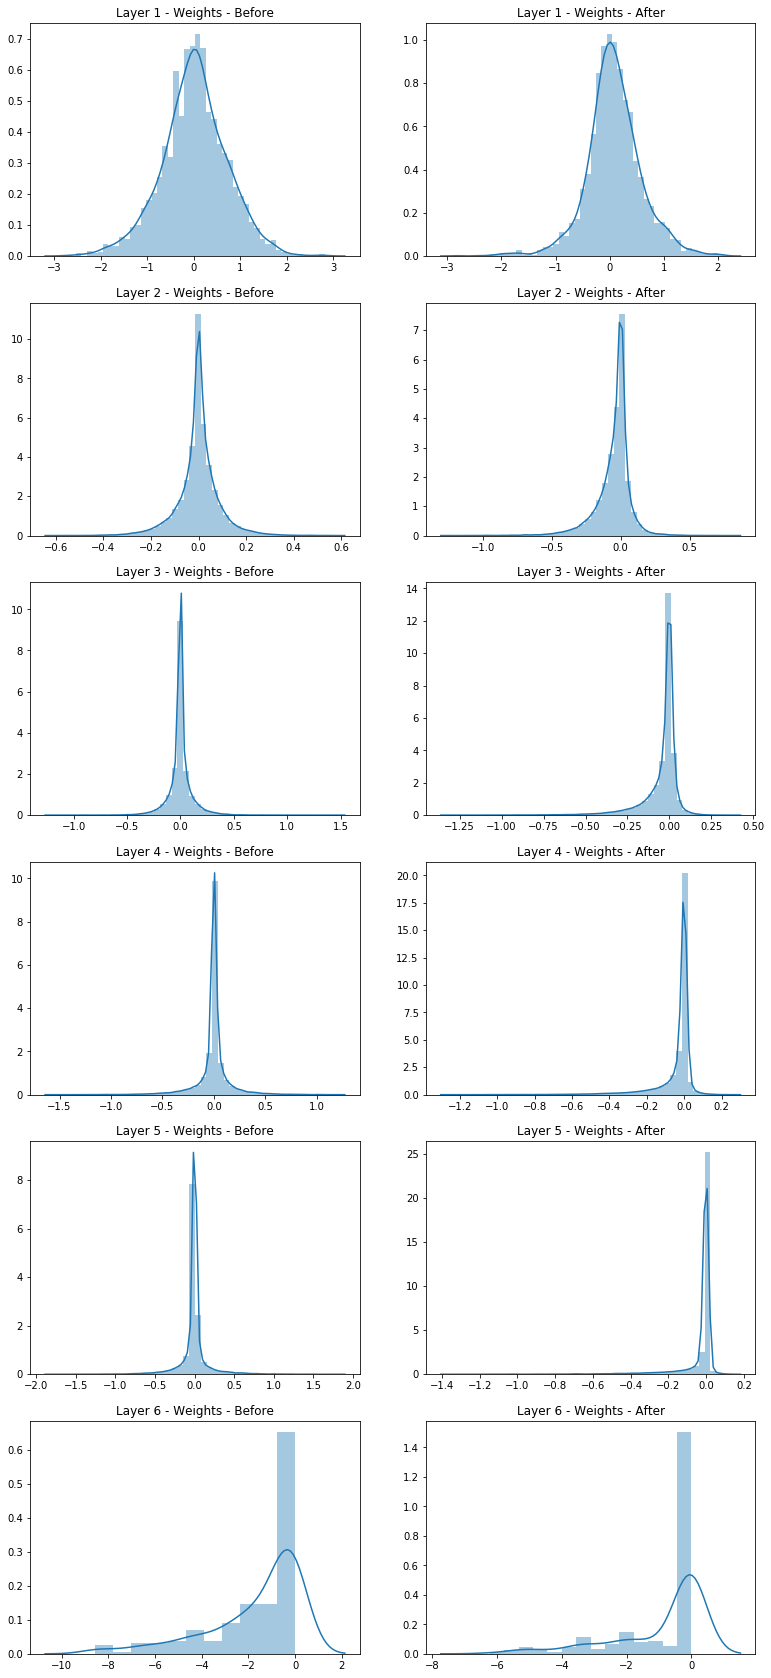

In [23]:
import seaborn
import matplotlib.pyplot as plt

print

# Flatten the list
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13, 30))

axes[0, 0].set_title("Layer 1 - Weights - Before")
seaborn.distplot(layers_before[0]["weights"], label="0", ax=axes[0, 0])
axes[0, 1].set_title("Layer 1 - Weights - After")
seaborn.distplot(layers_after[0]["weights"], label="0", ax=axes[0, 1])

axes[1, 0].set_title("Layer 2 - Weights - Before")
seaborn.distplot(layers_before[1]["weights"], label="0", ax=axes[1, 0])
axes[1, 1].set_title("Layer 2 - Weights - After")
seaborn.distplot(layers_after[1]["weights"], label="0", ax=axes[1, 1])

axes[2, 0].set_title("Layer 3 - Weights - Before")
seaborn.distplot(layers_before[2]["weights"], label="0", ax=axes[2, 0])
axes[2, 1].set_title("Layer 3 - Weights - After")
seaborn.distplot(layers_after[2]["weights"], label="0", ax=axes[2, 1])

axes[3, 0].set_title("Layer 4 - Weights - Before")
seaborn.distplot(layers_before[3]["weights"], label="0", ax=axes[3, 0])
axes[3, 1].set_title("Layer 4 - Weights - After")
seaborn.distplot(layers_after[3]["weights"], label="0", ax=axes[3, 1])

axes[4, 0].set_title("Layer 5 - Weights - Before")
seaborn.distplot(layers_before[4]["weights"], label="0", ax=axes[4, 0])
axes[4, 1].set_title("Layer 5 - Weights - After")
seaborn.distplot(layers_after[4]["weights"], label="0", ax=axes[4, 1])

axes[5, 0].set_title("Layer 6 - Weights - Before")
seaborn.distplot(layers_before[5]["weights"], label="0", ax=axes[5, 0])
axes[5, 1].set_title("Layer 6 - Weights - After")
seaborn.distplot(layers_after[5]["weights"], label="0", ax=axes[5, 1])

plt.show()

# Optimización de red deep

In [47]:
def compile_network_for_f(lr=0.01, hidden_units=200, hidden_activation="sigmoid"):
    model = Sequential()
    model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(200,  kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model

In [54]:
model = compile_network_for_f(lr=0.005)
hist = model.fit(X_train_scaled, y_train, epochs=200,
        verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))

In [55]:
model = compile_network()
hist2 = model.fit(X_train_scaled, y_train, epochs=200,
        verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))

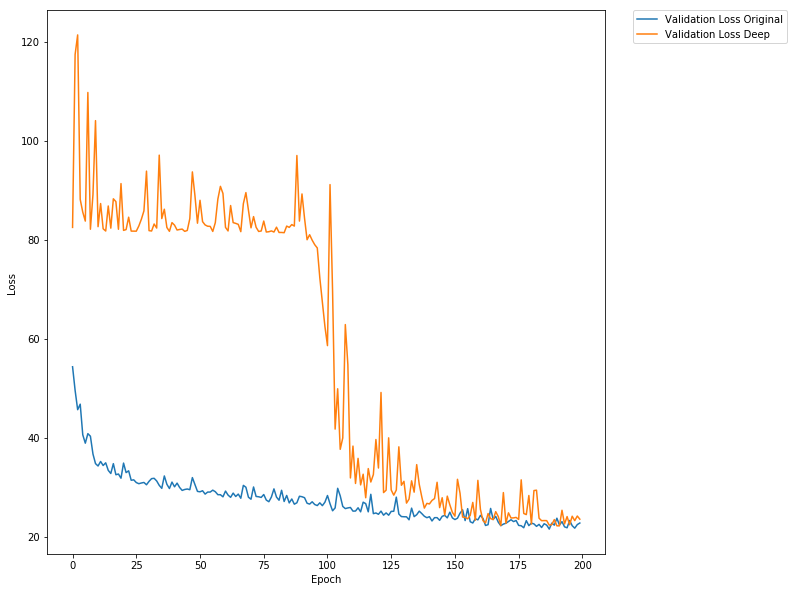

In [56]:
import matplotlib.pyplot as plt
loss_x = range(0, 200)

val_loss_y = hist.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 10))
plt.plot(loss_x, hist2.history['val_loss'], label="Validation Loss Original")
plt.plot(loss_x, hist.history['val_loss'], label="Validation Loss Deep")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.show()

Se puede observar que la convergencia de la función de perdida es mejor en la red original que en la red neuronal profunda con 6 capas. Para poder mejorar la velocidad de convergencia de la red neuronal, se propone el siguiente esquema y parámetros:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 200)               3000      
_________________________________________________________________
dense_162 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_163 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_164 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_165 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_166 (Dense)            (None, 1)                 201       
Total params: 164,001
Trainable params: 164,001
Non-trainable params: 0
_________________________________________________________________


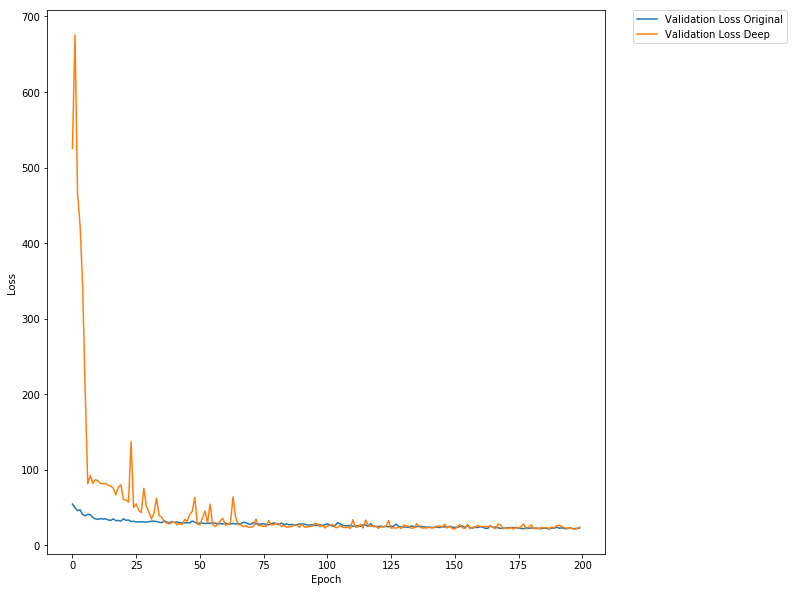

In [69]:
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
model.add(Dense(200,  kernel_initializer='uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.002)
model.compile(optimizer=sgd,loss='mean_squared_error')
model.summary()
hist = model.fit(X_train_scaled, y_train, epochs=200,
        verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test))

val_loss_y = hist.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 10))
plt.plot(loss_x, hist2.history['val_loss'], label="Validation Loss Original")
plt.plot(loss_x, hist.history['val_loss'], label="Validation Loss Deep")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.show()

La arquitectura definida anteriormente logra converger a una velocidad much mayor que originalmente y logra incluso tener mejor o igual error que la red con una sola capa

# Efecto de conversión de red deep a shallow

In [78]:
def compile_network_for_g(lr=0.01, hidden_units=200, hidden_activation="sigmoid"):
    model = Sequential()
    model.add(Dense(1000, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd,loss='mean_squared_error')
    return model

In [83]:
model = compile_network_for_g(lr=0.00000001)
hist = model.fit(X_train_scaled, y_train, epochs=200,
        verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test))

Train on 379 samples, validate on 127 samples
Epoch 1/200
379/379 [==============================] - 1s 2ms/step - loss: 41715632588174320.0000 - val_loss: 8975379427192227840.0000
Epoch 2/200
379/379 [==============================] - 0s 65us/step - loss: 10483037386470612966086751027200.0000 - val_loss: 2100621297935839724255467783847936.0000
Epoch 3/200
379/379 [==============================] - 0s 59us/step - loss: nan - val_loss: nan               
Epoch 4/200
379/379 [==============================] - 0s 80us/step - loss: nan - val_loss: nan
Epoch 5/200
379/379 [==============================] - 0s 61us/step - loss: nan - val_loss: nan
Epoch 6/200
379/379 [==============================] - 0s 73us/step - loss: nan - val_loss: nan
Epoch 7/200
379/379 [==============================] - 0s 91us/step - loss: nan - val_loss: nan
Epoch 8/200
379/379 [==============================] - 0s 69us/step - loss: nan - val_loss: nan
Epoch 9/200
379/379 [==============================] - 0s 83us

379/379 [==============================] - 0s 80us/step - loss: nan - val_loss: nan
Epoch 84/200
379/379 [==============================] - 0s 88us/step - loss: nan - val_loss: nan
Epoch 85/200
379/379 [==============================] - 0s 91us/step - loss: nan - val_loss: nan
Epoch 86/200
379/379 [==============================] - 0s 90us/step - loss: nan - val_loss: nan
Epoch 87/200
379/379 [==============================] - 0s 73us/step - loss: nan - val_loss: nan
Epoch 88/200
379/379 [==============================] - 0s 87us/step - loss: nan - val_loss: nan
Epoch 89/200
379/379 [==============================] - 0s 80us/step - loss: nan - val_loss: nan
Epoch 90/200
379/379 [==============================] - 0s 102us/step - loss: nan - val_loss: nan
Epoch 91/200
379/379 [==============================] - 0s 85us/step - loss: nan - val_loss: nan
Epoch 92/200
379/379 [==============================] - 0s 88us/step - loss: nan - val_loss: nan
Epoch 93/200
379/379 [====================

Epoch 167/200
379/379 [==============================] - 0s 77us/step - loss: nan - val_loss: nan
Epoch 168/200
379/379 [==============================] - 0s 84us/step - loss: nan - val_loss: nan
Epoch 169/200
379/379 [==============================] - 0s 70us/step - loss: nan - val_loss: nan
Epoch 170/200
379/379 [==============================] - 0s 79us/step - loss: nan - val_loss: nan
Epoch 171/200
379/379 [==============================] - 0s 78us/step - loss: nan - val_loss: nan
Epoch 172/200
379/379 [==============================] - 0s 84us/step - loss: nan - val_loss: nan
Epoch 173/200
379/379 [==============================] - 0s 80us/step - loss: nan - val_loss: nan
Epoch 174/200
379/379 [==============================] - 0s 81us/step - loss: nan - val_loss: nan
Epoch 175/200
379/379 [==============================] - 0s 81us/step - loss: nan - val_loss: nan
Epoch 176/200
379/379 [==============================] - 0s 76us/step - loss: nan - val_loss: nan
Epoch 177/200
379/37

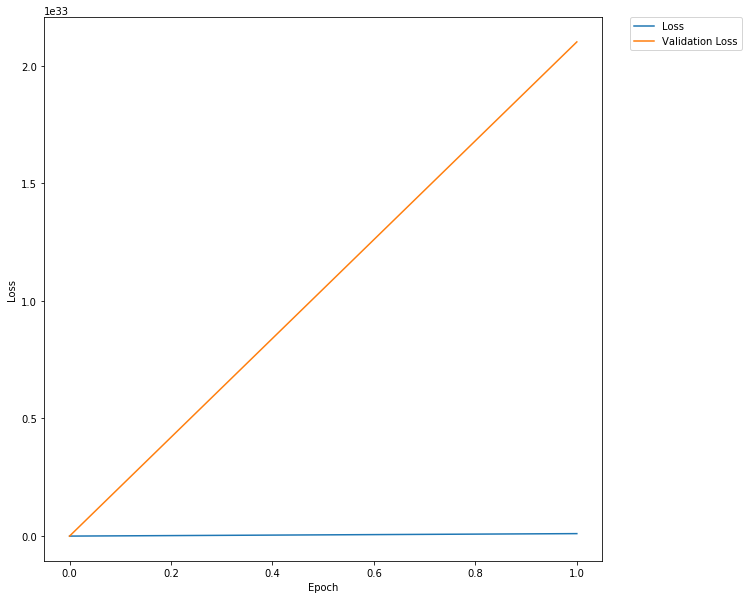

In [84]:
import matplotlib.pyplot as plt
loss_x = range(0, 200)

val_loss_y = hist.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 10))
plt.plot(loss_x, hist.history['loss'], label="Loss")
plt.plot(loss_x, hist.history['val_loss'], label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.show()

Como se puede observar, esta red no converge de forma adecuada, independiente del valor de learning rate que se propicie. Esto sucede debido a que durante back propagation, la derivada de cada peso respecto a la función de perdida termina haciendo que los pesos tomen valores demasiado grandes que no pueden ser representados computacionalmente.